# Bone Metastasis Classification on Sample from Dataset

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

### Load Data

In [2]:
# Classes for normal (no metastasis) and abnormal (metastasis)
classes = [0, 1]
# Amount of images to pass through the model in one minibatch
batch_size = 4
# Function to transform image in dataset before passing through model
transform = transforms.ToTensor()

In [3]:
# Dataset and dataloader for training data
trainset = datasets.ImageFolder(root=r"dataset-sample\train", transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

Classes: 0 0 0 1


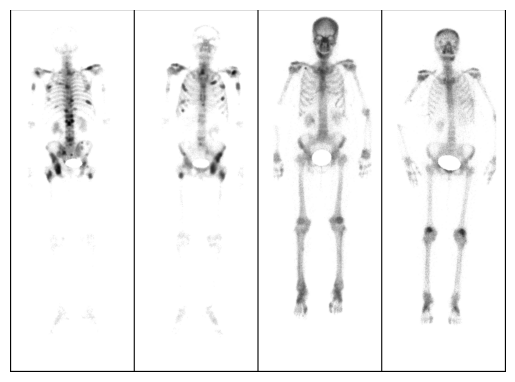

In [4]:
# Show random images from training data and their ground truth classes
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [5]:
# DEPRECATED
class CustomDataset(Dataset):
    def __init__(self, labels_filepath, img_dir):
        self.img_dir = img_dir
        self.img_labels = labels_filepath
        self.transform = ToTensor()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # Read image as greyscale
        image = Image.open(img_path)#.convert("L")
        # Convert PIL Image to tensor, scale values to range [0, 1]
        image = self.transform(image)
        label = self.img_labels.iloc[idx, 1]
        return image, label

### Define Model

In [6]:
# Create model with CNN and MLP for classification
class CustomModel(nn.Module):
    
    # Define layers
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 3, 
                              out_channels = 3, 
                              kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 3 * 158 * 52,
                             out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, 
                             out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, 
                             out_features = 2)

    # Apply layers
    def forward(self, x):
        # CNN layers for convoltion
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(F.relu(self.conv(x)))
        # Flatten all dimensions except batch
        x = torch.flatten(input = x, start_dim = 1)
        
        # MLP layers for classification
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(input = x, dim = 1)
        
        return x

In [7]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [8]:
# Instantiate model
model = CustomModel()

In [9]:
# Define criterion (function used to compute loss) and optimizer for model
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train Model

In [10]:
epochs = 10
losses = []
batch_count = 0

In [11]:
# Train model
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    running_loss = 0
    
    for batch_index, batch_data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [images, labels]
        images, labels = batch_data

        # Forward pass
        predictions = model(images) # Pass input through model.forward()
        loss = criterion(predictions, labels) # Compute loss against ground truth labels
        
        # Backpropagation
        optimizer.zero_grad() # Reset gradients from previous passes
        loss.backward() # Compute gradients using derivative of loss
        optimizer.step() # Update values using gradients

        running_loss += loss.item() # Add batch loss to current epoch loss
        batch_count += 1 # Increment number of finished batches
    
    running_loss = running_loss / batch_count
    losses.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("------------------")

print('Finished training model')

Epoch: 0
Loss: 0.7721980214118958
------------------
Epoch: 1
Loss: 0.3759414354960124
------------------
Epoch: 2
Loss: 0.24343550205230713
------------------
Epoch: 3
Loss: 0.1782737672328949
------------------
Epoch: 4
Loss: 0.13917727867762247
------------------
Epoch: 5
Loss: 0.11879983875486586
------------------
Epoch: 6
Loss: 0.09968565759204683
------------------
Epoch: 7
Loss: 0.08737109849850337
------------------
Epoch: 8
Loss: 0.07702048398830273
------------------
Epoch: 9
Loss: 0.06934661865234375
------------------
Finished training model


### Evaluate Model

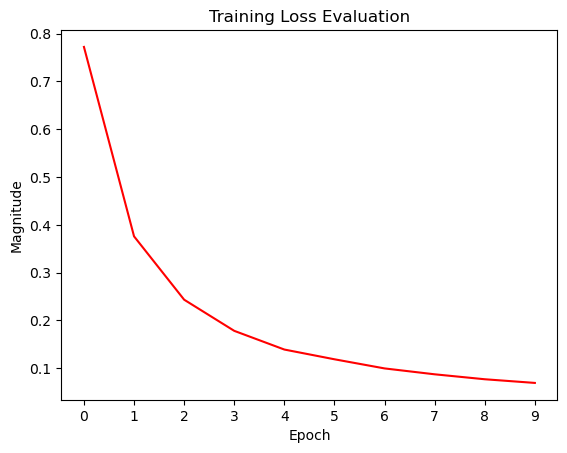

In [12]:
# Plot losses
ax = plt.axes()
plt.plot(losses, color='red')
plt.title('Training Loss Evaluation')
ax.set_xticks([x for x in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.show()

### Test Model on Test Dataset

In [13]:
testset = datasets.ImageFolder(root=r"dataset-sample\test", transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Actual Classes: 0 0 1 1


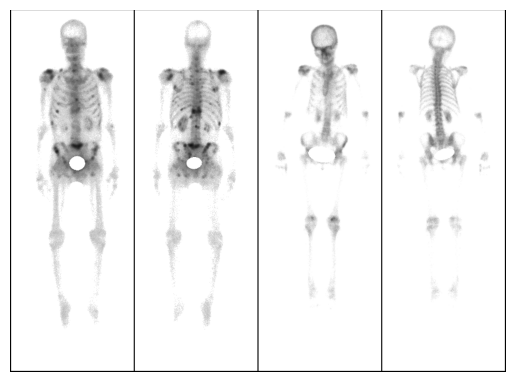

In [14]:
# Show sample images from test data and their ground truth classes
dataiter = iter(testloader)
images, labels = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Actual Classes: " + ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [15]:
correct_predictions = 0
total_predictions = 0

print("Model predictions on test dataset:")

with torch.no_grad(): # Without updating gradients
    for data in testloader:
        images, labels = data
        outputs = model(images) # Pass input through model.forward()
        
        # Choose class with the highest probability as the prediction for that image
        _, predicted = torch.max(input = outputs.data, dim = 1)
        
        for index in range(predicted.size(dim=0)):
            print(f"Predictions: {outputs[index]}")
            print(f"Actual Class: {labels[index]}   Predicted Class: {predicted[index]}\n")
        
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

print(f'Model accuracy on {total_predictions} test images: {100 * correct_predictions // total_predictions}%')

Model predictions on test dataset:
Predictions: tensor([0.5408, 0.4592])
Actual Class: 0   Predicted Class: 0

Predictions: tensor([0.5408, 0.4592])
Actual Class: 0   Predicted Class: 0

Predictions: tensor([0.5407, 0.4593])
Actual Class: 1   Predicted Class: 0

Predictions: tensor([0.5407, 0.4593])
Actual Class: 1   Predicted Class: 0

Model accuracy on 4 test images: 50%
